In [168]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
from google.colab import drive
import os

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/sysrec/TFIDF_CB/") 

fileNames = os.listdir()
print(fileNames)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['dataset.csv', 'NLP-Course-TelU', 'Dataset_LirikLagu.csv', 'TFIDF.ipynb']


In [169]:
df = pd.read_csv('Dataset_LirikLagu.csv')
df.head()

,No_IDLagu,Judul_Lagu,Bait_Reff,NIM,Nama
0,1,Kukira Kau Rumah,Kukira kau rumah\nNyatanya kau cuma aku sewa\n...,1301170262,Fadhli Kamil Maulana
1,2,Monolog,Alasan masih bersama\nBukan karena terlanjur l...,1301170262,Fadhli Kamil Maulana
2,3,Bila,"Bila saja dikau bisa berbicara, oh\nIzinkan da...",1301170262,Fadhli Kamil Maulana
3,4,Seberapa Pantas,Celakanya\nHanya kaulah yang benar-benar aku t...,1301174510,Naufal Adi Nugroho
4,5,Dekat di Hati,Aku di sini dan kau di sana\nHanya berjumpa vi...,1301174510,Naufal Adi Nugroho


Text Cleaning and Preparation


1.  remove special character



In [170]:
import string

df['reff_clean'] = df['Bait_Reff'].str.replace("\r", " ")
df['reff_clean'] = df['reff_clean'].str.replace("\n", " ")
df['reff_clean'] = df['reff_clean'].str.replace('"','')
df['reff_clean'] = df['reff_clean'].str.lower()
df['reff_clean'] = df['reff_clean'].str.translate(str.maketrans("","",string.punctuation))

2. remove punctuation

In [171]:
punct_sign = list("?:!.,;")
for punct in punct_sign:
  df['reff_clean'] = df['reff_clean'].str.replace(punct,'')

3. stemming

In [172]:
# !pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()
 
for idx, row in df.iterrows():
  temp_lirik = df.loc[idx,'reff_clean']
  hasil = stemmer.stem(temp_lirik)
  df.loc[idx, 'reff_clean'] = hasil

In [173]:
#re-arrange column
df = df[['No_IDLagu', 'Judul_Lagu', 'Bait_Reff','reff_clean', 'NIM', 'Nama']]
df.head()

,No_IDLagu,Judul_Lagu,Bait_Reff,reff_clean,NIM,Nama
0,1,Kukira Kau Rumah,Kukira kau rumah\nNyatanya kau cuma aku sewa\n...,kira kau rumah nyata kau cuma aku sewa dari tu...,1301170262,Fadhli Kamil Maulana
1,2,Monolog,Alasan masih bersama\nBukan karena terlanjur l...,alas masih sama bukan karena lanjur lama tapi ...,1301170262,Fadhli Kamil Maulana
2,3,Bila,"Bila saja dikau bisa berbicara, oh\nIzinkan da...",bila saja dikau bisa bicara oh izin daku pergi...,1301170262,Fadhli Kamil Maulana
3,4,Seberapa Pantas,Celakanya\nHanya kaulah yang benar-benar aku t...,celaka hanya kau yang benarbenar aku tunggu ha...,1301174510,Naufal Adi Nugroho
4,5,Dekat di Hati,Aku di sini dan kau di sana\nHanya berjumpa vi...,aku di sini dan kau di sana hanya jumpa via su...,1301174510,Naufal Adi Nugroho


Most common word

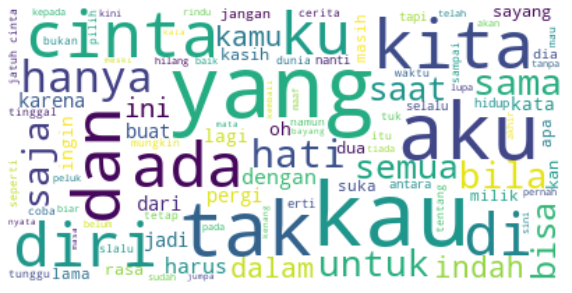

In [174]:
# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = df['reff_clean'].tolist()
text = ' '.join(text)
wc = WordCloud(max_words=100, background_color="white").generate(text)
plt.figure( figsize=(10,6) )
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [175]:
#function that return top5 similiar reff with inputed ID
def top5(id):
  row = df.loc[df.No_IDLagu == id].index.tolist()[0]
  title = df[df.No_IDLagu == id].Judul_Lagu.values[0]

  #calculate tf-idf weight
  tfidf_vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True)
  tfidf_matrix = tfidf_vectorizer.fit_transform(df.reff_clean.values)
  features = tfidf_vectorizer.get_feature_names()
  similiar_tfidf = pd.Series(tfidf_matrix.getrow(row).toarray().flatten(), index = features).sort_values(ascending = False)

  #create a K-nn model
  knn_neighbours = NearestNeighbors(n_neighbors=6)
  knn_neighbours.fit(tfidf_matrix)

  #evaluate result and convert to dataframe
  closest_song = knn_neighbours.kneighbors(tfidf_matrix.getrow(row), return_distance = True)
  idx = closest_song[1][0]
  song = [df.loc[i]['Judul_Lagu'] for i in idx]
  id_lagu = [df.loc[i]['No_IDLagu'] for i in idx]
  distances = closest_song[0][0]
  distances = [round(i,3) for i in distances]
  songs = df[df.Judul_Lagu.isin(song)]

  #If it is the case, we delete the name that has distance zero.
  if distances[0]==0.0: distances,id_lagu,song = np.delete(distances,0),np.delete(id_lagu,0),np.delete(song,0)
  
  data = pd.DataFrame({'NoID_Lagu': id_lagu,'Distances': distances,'Title Song': song })
  return data


Input data

In [176]:
id = int(input('Input ID: '))
print('Top 5 song similiar with id ', id,'\nTitle: ', df[df.No_IDLagu == id].Judul_Lagu.values[0]) 
display(top5(id))

Input ID: 54
Top 5 song similiar with id  54 
Title:  Awas Nanti Jatuh Cinta


,NoID_Lagu,Distances,Title Song
0,29,1.111,Berdistraksi
1,16,1.149,Janji di Atas ingkar
2,7,1.158,Risalah Hati
3,56,1.165,Kamu dan Kenangan
4,12,1.201,Menghujam Jantungku
